# **Note: To use the same paths without any updates, you can upload the unzipped folder to your goodle drive account**
### **This file provides codes for:**
###- Text data pre-processing 
###- Numerical data re-processing
###- Visualizations for exploratory data analysis purposes
###- Splitting the main dataset into training set and testing set (saved as 'pickle' objects) for modeling purposes  

In [2]:
!pip install isodate

     |████████████████████████████████| 41 kB 519 kB/s 


In [3]:
# Import packages
from google.colab import drive
import pandas as pd
import numpy as np
import requests
import json
import time
from datetime import datetime
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import wordnet
from collections import Counter
import matplotlib.pyplot as plt
import isodate
from sklearn.model_selection import train_test_split

In [5]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Path to the main directory
folder_path = folder_path = '/content/gdrive/My Drive/FinalProject_LakshyanaKC_NhatPham/Data/'
recipe_path = folder_path + "recipes.csv"
data = pd.read_csv(recipe_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [ ]:
# we need ratings, so remove those with "nan" ratings
data = data[~np.isnan(data['AggregatedRating'])]

In [ ]:
# Convert ratings to 1,2,3,4,5 ratings
remap_cat_dict = {1: 1,1.5: 1, 2: 2, 2.5: 2,3: 3,3.5: 3,4: 4, 4.5: 4, 5: 5}
data['RatingId']= data.AggregatedRating.map(remap_cat_dict).astype('category')
count = data.RatingId.value_counts()
count.plot.bar()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5    174516
4     77159
3     13144
2      2722
1      1753
Name: RatingId, dtype: int64

In [ ]:
data['RatingId'] =data['RatingId'].replace([1],2)
data.RatingId.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


5    174516
4     77159
3     13144
2      4475
Name: RatingId, dtype: int64

# **Process Text Data**

In [ ]:
#preprocess data

nltk.download('omw-1.4')
nltk.download('stopwords')

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


stopwords = nltk.corpus.stopwords.words("english")
lemma     = nltk.stem.WordNetLemmatizer()
punkt     = nltk.download('punkt')

def get_part_of_speech(word): 
  """
  create a part-of-speech tagging function
  input: a word
  return: the most likely part of speech for that word
  """
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
"""
Preprocess the text features.
1. Cleanup the text
2. Add sentence start and end tokens,
3. Lowercase text 
4. tokenize, remove stop words, and lemmatize text
"""
def preprocess(x):
  x = str(x)
  # Remove 'c("', '")', 
  x = re.sub(r'c\("','<s> ', x)
  x = re.sub(r'[\(\"\)\n\\]|nan', '', x) # Remove '(,),\n"' signs and 'nan'
  x = re.sub(r'\.+,|\.+', '.', x)  # Replace '.,', "..." with just '.'

  # Add space between alphabet and numeric charecters
  regex = r"(?i)(?<=\d)(?=[a-z°])|(?<=[a-z°])(?=\d)| +"  # "| +" to replace many spaces with one
  x = re.sub(regex, " ", x)

  # Replace "/" symbols between two words with or
  regex = r"([a-zA-Z ])[\/]+(?=[a-zA-Z ])"
  x = re.sub(regex, r'\1 or ', x)

  # Find end of sentence punctuations like "!","?","." (add . if it's followed by space)
  # Add end of sentence with begin and end of sentence tags
  x = re.sub(r'(?<=[.?!])( +|\Z)',' </s> \n <s> ', x) 
  # x = #remove the last <s> tag if text has '.' at the end 

  # Lowercase text
  x = x.lower()

  # Remove punctuations apart from sentence tags and newline
  x = re.sub(r'\-| +\- +', ' ', x) # Replace '/' between alphabets, "-", " - " with just ' '
  x = re.sub(r'[^\w\s\</s>\<s>\\n]+', '', x) #not including apostrophe \'

  # Add end of sentence token in the last sentence if not present
  x = x + ' </s>' if x[-4:] != '</s>' and x!= ''  else x
  # Add start of sentence token in the first sentence if not present
  x = '<s> '+ x if x[0:3] != '<s>' and x!= ''  else x

  # Remove blank sentences <s> spaces </s> and 'nan'
  x = re.sub(r"\<s> +\</s>", '', x) 

  # 2. Extract tokens
  # tokens = nltk.word_tokenize(x)
  sentences = [sentence.split() for sentence in x.split('\n')]

  # 3. Remove stopword
  
  sentences = [[word for word in tokens if word not in stopwords] for tokens in sentences]

  # 4. Lemmatize
  # nltk_tagged = nltk.pos_tag(tokens) 
  # wordnet_tagged = map(lambda x: (x[0], nltk_position_tagger(x[1])), nltk_tagged)
  # tokens = [[lemma.lemmatize(word, tag) if tag != None else word] for word,tag in wordnet_tagged]
  tokens = [[lemma.lemmatize(word, get_part_of_speech(word)) for word in tokens] for tokens in sentences]
  
  sentences = [" ".join(sentence) for sentence in tokens]
  paragraph = " ".join(sentences)
  return paragraph



def preprocessList(x):
  x = str(x)
  # Remove 'c("', '")', 
  x = re.sub(r'c\(|\)','', x)
  x = re.sub(r'\-|\/', ' ', x) # Replace '/' between alphabets, "-", " - " with just ' '
  x = re.sub(r'[\n\\]|nan', '', x) # Remove '(,),\n"' signs and 'nan'
  
  # Replace "/" symbols between two words with or
  regex = r"([a-zA-Z ])[\/]+(?=[a-zA-Z ])"
  x = re.sub(regex, r'\1 or ', x)

  # Lowercase text
  x = x.lower()

  # Remove punctuations apart from sentence tags and newline
  x = re.sub(r'[^\w\s\"]+', '', x) #not including apostrophe \'
  # Replace multiple spaces with one
  x = re.sub(r' +', ' ', x) #not including apostrophe

  # Replace " " between ingredients with "," 
  x = re.sub(r'\" +"', ',', x) 
  
  # Remove the remaining " 
  x = re.sub(r'["]', '', x) #not including apostrophe \'

  # Replace space between each ingredient with "-"
  x = re.sub(r' ', '-', x) #not including apostrophe

  # Now replace "," back to " "
  x = re.sub(r'\,',' ', x) 

  # 2. Extract tokens
  tokens = x.split()

  return tokens


In [ ]:
data['RecipeInstructions'] = data['RecipeInstructions'].apply(preprocess)
data['RecipeIngredientParts'] = data['RecipeIngredientParts'].apply(preprocessList)
data['Keywords'] = data['Keywords'].apply(preprocessList)


In [ ]:
data['Keywords'][:5]

0    [dessert, low-protein, low-cholesterol, health...
1    [chicken-thigh-leg, chicken, poultry, meat, as...
2    [low-protein, low-cholesterol, healthy, summer...
3    [beans, vegetable, low-cholesterol, weeknight,...
4    [low-protein, vegan, low-cholesterol, healthy,...
Name: Keywords, dtype: object

In [ ]:
data['RecipeIngredientParts'][:5]

0    [blueberries, granulated-sugar, vanilla-yogurt...
1    [saffron, milk, hot-green-chili-peppers, onion...
2    [sugar, lemons-rind-of, lemon-zest-of, fresh-w...
3    [extra-firm-tofu, eggplant, zucchini, mushroom...
4    [plain-tomato-juice, cabbage, onion, carrots, ...
Name: RecipeIngredientParts, dtype: object

In [ ]:
data['RecipeInstructions'][:5]

0    <s> toss 2 cup berry sugar </s> <s> let stand ...
1    <s> soak saffron warm milk 5 minute puree blen...
2    <s> 1 quart jar tight fit lid put sugar lemon ...
3    <s> drain tofu carefully squeeze excess water ...
4    <s> mix everything together bring boil </s> <s...
Name: RecipeInstructions, dtype: object

# **Process Numerical Data**

In [ ]:
# Convert duration variables (from ISO8061 format) to minutes
dateCol = ['PrepTime','TotalTime','CookTime']
for col in dateCol:
  data[col] = np.where(data[col].isnull(), 0, data[col].str.replace('[^\w\s]','')  )
  data[col] = data[col].apply(lambda x: isodate.parse_duration(x) if x!=0 else 0)
  data[col] = data[col].apply(lambda x: x.total_seconds()/60 if x!=0 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
def str_to_list(x):
  if (str(x)[:3]=='c("' and str(x)[-2:]=='")'):
    x = str(x)[3:-2]
    x_list = list(str(x).split('", "'))
  elif (str(x)[0] =='"' and str(x)[-1]=='"'):
    x_list = [str(x)[1:-1]]

  else:
    x_list = ''
  return (x_list)

# Change 'Images' to number of images
data['Images'] = data['Images'].apply(str_to_list)
data['Images'] = data['Images'].apply(lambda x: len(x))

In [ ]:
# Description: 0 if empty or 'Make and share' (auto descripton from Food.com)
data['Description'] = data['Description'].apply((lambda x: 0 if x == '' else (0 if str(x).startswith('Make and share') else 1)))

In [ ]:
data.drop(['RecipeYield','RecipeServings','AuthorName','AuthorId','DatePublished'],inplace=True, axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269294 entries, 0 to 522431
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   RecipeId                    269294 non-null  int64   
 1   Name                        269294 non-null  object  
 2   CookTime                    269294 non-null  float64 
 3   PrepTime                    269294 non-null  float64 
 4   TotalTime                   269294 non-null  float64 
 5   Description                 269294 non-null  int64   
 6   Images                      269294 non-null  int64   
 7   RecipeCategory              269049 non-null  object  
 8   Keywords                    269294 non-null  object  
 9   RecipeIngredientQuantities  269292 non-null  object  
 10  RecipeIngredientParts       269294 non-null  object  
 11  AggregatedRating            269294 non-null  float64 
 12  ReviewCount                 269294 non-null  float64 
 13 

In [ ]:
with open('fulldata_processed.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# **Visualizations**

In [ ]:
def identity_tokenizer(text):
    return text

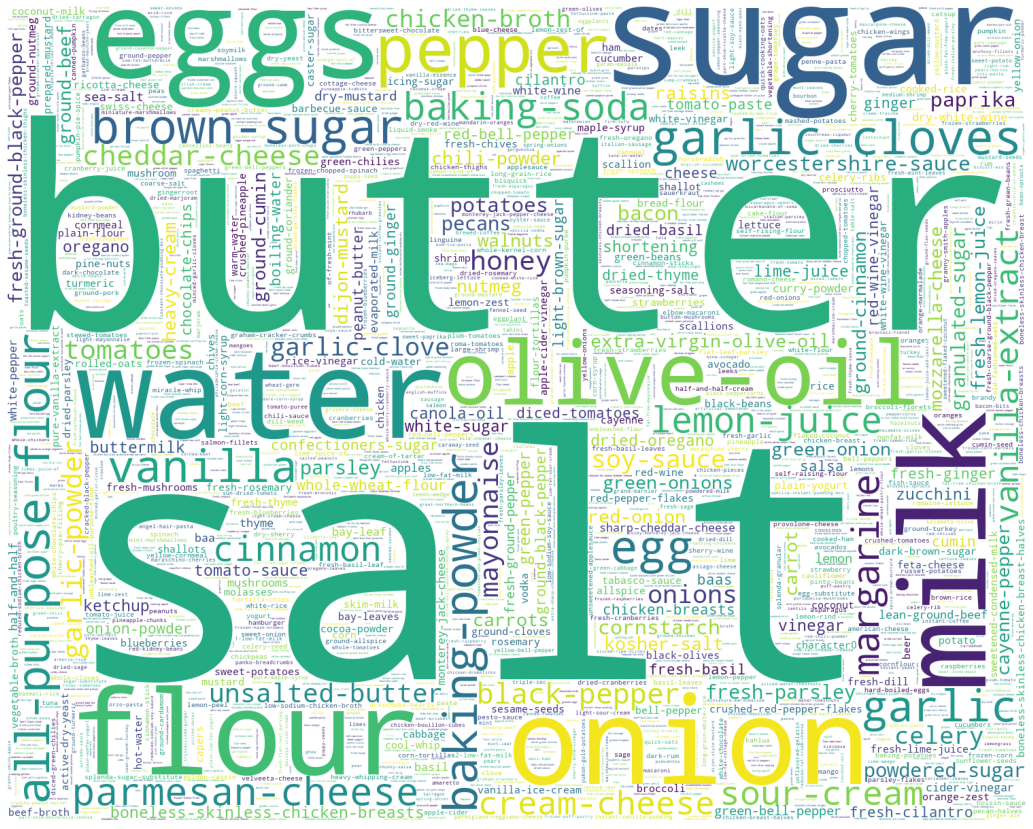

In [ ]:
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, use_idf=True)    
features = tfidf.fit_transform(data['RecipeIngredientParts'])
#finally lets create the wordcloud. 
tfidf_weights = [(word, features.getcol(idx).sum()) for word, idx in tfidf.vocabulary_.items()]

w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('category_wordcloud.png')

(-0.5, 1499.5, 1199.5, -0.5)

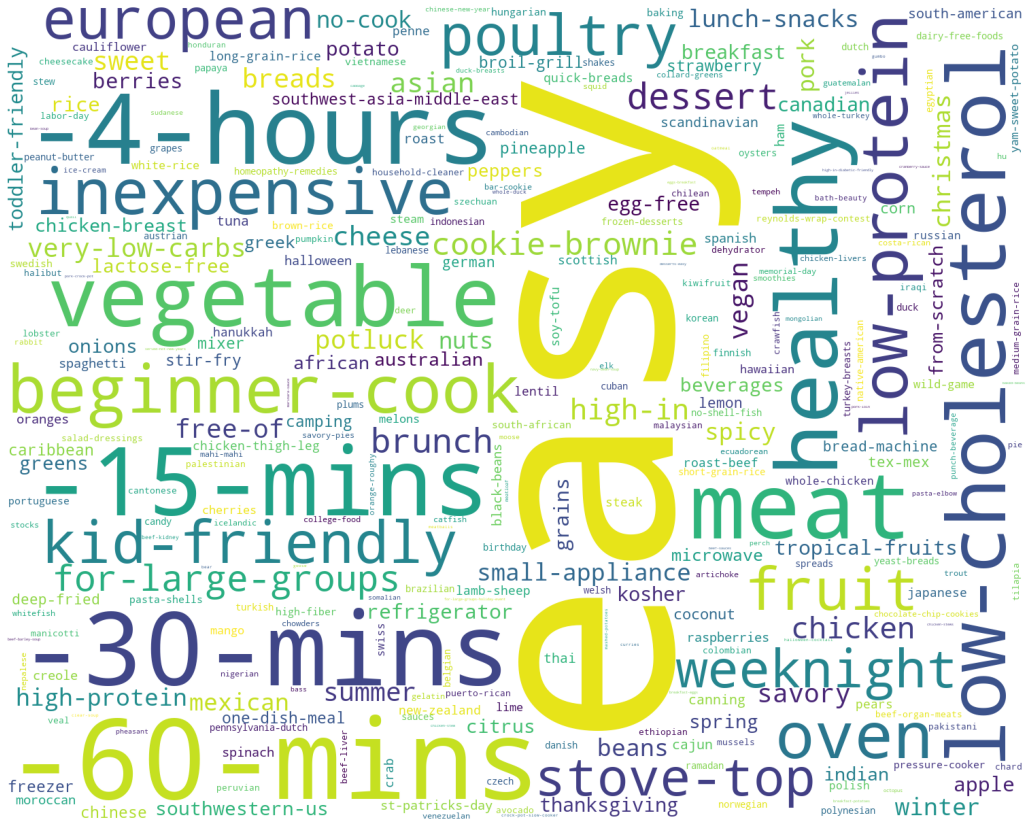

In [ ]:
features = tfidf.fit_transform(data['Keywords'])
#finally lets create the wordcloud. 
tfidf_weights = [(word, features.getcol(idx).sum()) for word, idx in tfidf.vocabulary_.items()]

w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('keywords_wordcloud.png')

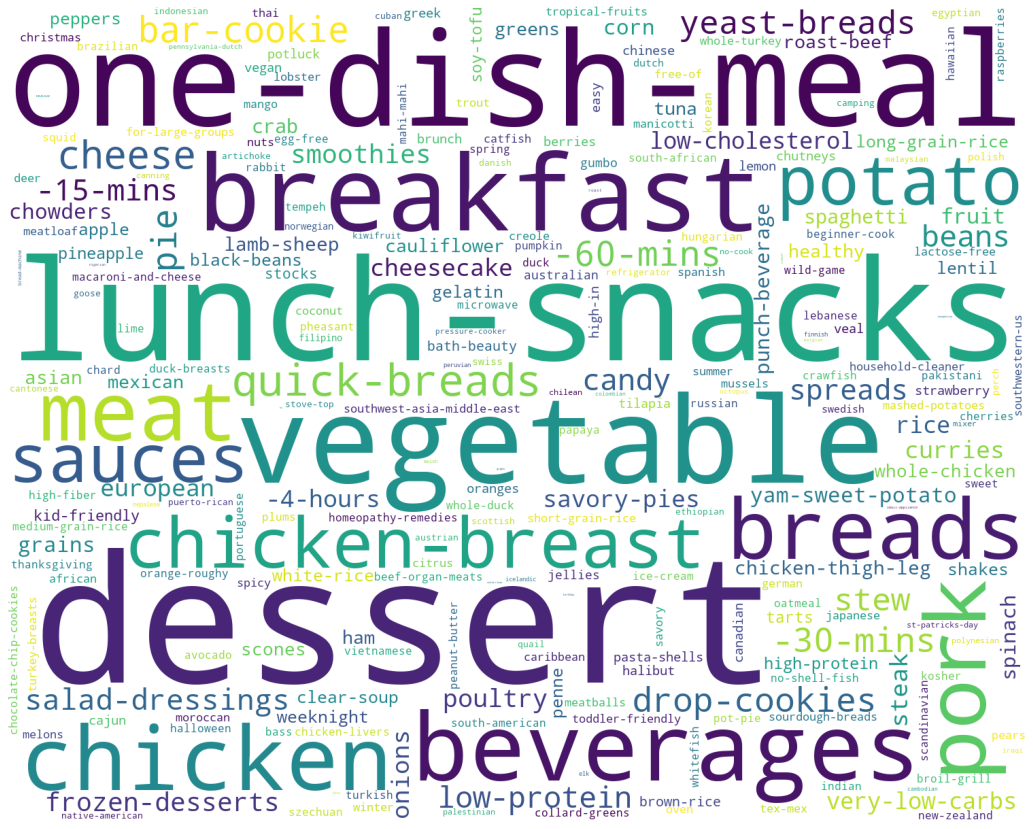

In [ ]:
features = tfidf.fit_transform(data['RecipeCategory'])
tfidf_weights = [(word, features.getcol(idx).sum()) for word, idx in tfidf.vocabulary_.items()]
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('category_wordcloud.png')

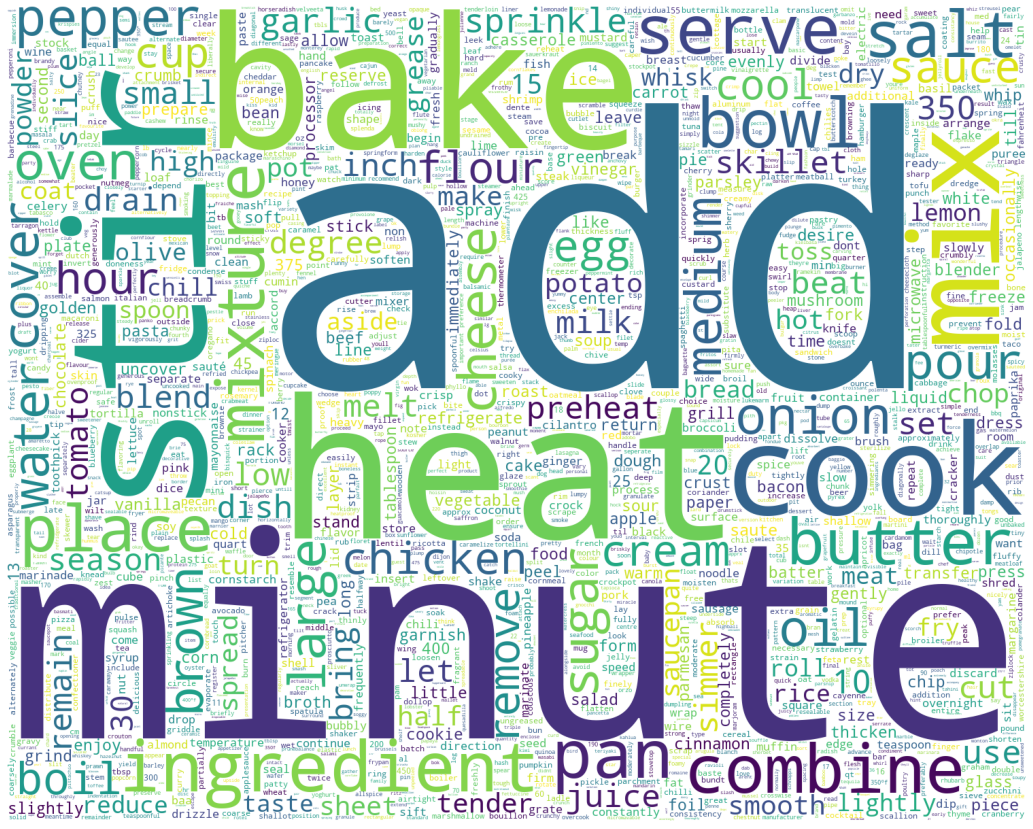

In [ ]:
tfidf2 = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', stop_words='english')
features = tfidf2.fit_transform(data['RecipeInstructions'])
tfidf2_weights = [(word, features.getcol(idx).sum()) for word, idx in tfidf2.vocabulary_.items()]

w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf2_weights))
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('instructions_wordcloud.png')

# **Split dataset into training data and testing data for machine learning models**

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.25, random_state=3)

In [ ]:
train_df.RatingId.value_counts()

5    130782
4     57966
3      9845
2      3377
Name: RatingId, dtype: int64

In [ ]:
test_df.RatingId.value_counts()

5    43734
4    19193
3     3299
2     1098
Name: RatingId, dtype: int64

In [ ]:
with open('train_df.pickle', 'wb') as handle:
    pickle.dump(train_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('test_df.pickle', 'wb') as handle:
    pickle.dump(test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)